In [1]:
# preamble

# set up environments base -> ATOMIC_GOES
# IJulia and Revise must be installed in the Julia base @version package environment.
# Sometimes perhaps an vscode extension
using Revise # does using Revise first allow for revising code in ATOMIC_GOES???
using Pkg
# Pkg.activate(joinpath(homedir(), "Projects/ATOMIC/ATOMIC_GOES/julia/ATOMIC_GOES"))
cd("/Users/deszoeks/Projects/ATOMIC/trade-cu-model/src/julia")
Pkg.activate(".")

# using ATOMIC_GOES
# using ATOMIC_GOES.DataIO

using Printf
# using FileIO
using Dates
using NCDatasets
using JLD2

# using StatsBase
# using ForwardDiff
using Statistics
using Interpolations
using LinearAlgebra
# using DSP

using PyPlot
# using PyCall
# using PythonPlot # unusably bad at handling julia types
# using CSV

using VaporSat # dev ../../deps/VaporSat

  Activating project at `~/Projects/ATOMIC/trade-cu-model/src/julia`


In [2]:
# utility functions; extend matplotlib

#=
using PythonPlot
using PythonCall
"Recast julia Arrays with missing as python masked arrays."
function PythonCall.Py(a::Array{Union{T,Missing},N}) where {T,N}
    np = PythonCall.pyimport("numpy")
    np.ma.masked_invalid(np.array(replace(a, missing => NaN)))
end
=#

using PyCall
using PyCall: PyObject

# allow for plotting with missing values
function PyCall.PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

"convert arrays with missings to masked python float64 arrays"
# msk(y) = ma.masked_invalid(np.array(replace(y, missing => NaN), dtype="float64"))


"plotf(f, x, args...)  function plot wrapper"
plotf(f, x, args...) = plot(f.(x), x, args...)

pd = permutedims

"midpoint averager"
mid(x) = 0.5*(x[1:end-1].+x[2:end]) # doesn't work for Int16

"missing to zero"
# m2z(x) = ismissing(x) ? 0 : x
m2z(x) = replace(x, missing=>0)

# statistics fcns
"anomaly"
anom(r, kwargs...) = r .- mean(r, kwargs...)

"runningmean(x, n=7, f=isfinite) n-point running mean points satisfying f(x)==true"
function runningmean(x, n=7, f=isfinite)
    notf2zero(x) = f(x) ? x : 0
    cs = cumsum(notf2zero.(x))
    ct = cumsum(f.(x))
    (cs[n+1:end] .- cs[1:end-n]) ./ (ct[n+1:end] .- ct[1:end-n])
end

recurse(f, x, n) = n>0 ? f(recurse(f, x, n-1)) : x
"abstractly composes f n times; recursef(f,3) = f∘f∘f = x->f(f(f(x))), without evaluating"
recursef(f,n) = reduce(∘, ntuple(_ -> f, n)) 

"declare arrays with elements of Union{Missing,T} unions"
similarmissing(s::Tuple, T::Type=Float64) = Array{Union{Missing, T}}(missing, s)
similarmissing(A::Array) = similarmissing(size(A), eltype(A))

"moving_average(A, m) m-point moving average of A"
function moving_average(A::AbstractArray, m::Int, cond=x->true)
    out = similar(A)
    R = CartesianIndices(A)
    Ifirst, Ilast = first(R), last(R)
    I1 = m÷2 * oneunit(Ifirst)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in max(Ifirst, I-I1):min(Ilast, I+I1)
            if cond(A[J]) # add condition, e.g. isfinite
                s += A[J]
                n += 1
            end
        end
        out[I] = s/n
    end
    return out
end

# means and helper functions

n2m(x) = isnan(x) ? missing : x
skipnan(x) = skipmissing(n2m.(x))

"replace nonmissing nonfinite by missing"
nisf2m(x) = !ismissing(x) && isfinite(x) ? x : missing
# usem e.g., mean( skipmissing(nisf2m.(x)) )

"upsample by factor n, between 2 points"
upsample1(x0, x1; n=10, a=(0:n)/n) = x0*(1-a) + x1*a

"upsample X by factor n, between points of vector x."
function upsample(x; n=10, a=(0:n)/n)
    X = zeros((length(x)-1)*n + 1)
    for i in eachindex( x[1:end-1] )
        X[n*(i-1)+1 .+ (0:n)] .= x[i]*(1 .- a) + x[i+1]*a
    end
    X
end

"\\xi(x) wrapper for upsampling linearly in log space"
ξ(x) = exp.(upsample(log.(x))) # 

ξ

In [3]:
# functions for thermodynamics

# using .VaporSat -> dev ../../deps/VaporSat

# VaporSat exports dqsdT, qsat
# here we overload some unexported methods in VaporSat

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K


# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)
LvK(T) = Lv(T-273.15)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

# use method from VaporSat qsat(p[Pa], T[C])
# note order of arguments and units
# "qsat(T[C], p[hPa])"
# qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.

# adiabatic lapse rate
lapse_ad = gravity/Cp

"moist adiabatic lapse rate p[Pa], T[K]"
lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(p,T-KelvinCelsius)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(p,T-KelvinCelsius)/(Rd*Cp*T*T))
# lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(T-273.0,p)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(T-273.0,p)/(Rd*Cp*T*T))

"parcel process adiabatic change in saturation vapor pressure, p[Pa], T[K]"
dqsatdz_moistad(p,T) = dqsdT(p,T-KelvinCelsius) * -lapse_moist(T,p) # negative
# Small inconsistencies between dqsdT (Bolton) 
# and lapse_moist (Rogers and Yau) methods
# are OK here.

"density temperature for liquid water loading (exact, or take default approximation)"
liqldfac(ql; rhoa_o_rhoL=0.001) = 1 - (1 - rhoa_o_rhoL) * ql
Tliqld(Tv, ql; p=1e5, rhoa=p/(Rd*Tv)) = Tv * liqldfac(ql; rhoa_o_rhoL=rhoa/1000.0)

Tliqld (generic function with 1 method)

In [4]:
# load data

# prefixer() = startswith(gethostname(), "sundog") ? "/mnt/c" : "/"
# datapath = joinpath(prefixer(), "Users/deszoeks/Data/ATOMIC/radiosonde/level2")
datapath = "../../data/flux"

# PSL flux data file
# EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc
psl = NCDataset(joinpath(datapath, "EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc"))
# mean(skipmissing(psl["hl_bulk"][:]))
# mean(skipmissing(psl["prate"][:])) # 0.031 mm/h

# E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
# P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # W/m^2

# sondes data file
datapath = joinpath(homedir(),"Data/ATOMIC/radiosonde/level2")
# readdir(datapath)
ncfile = filter(x-> startswith(x,"EUREC4A_RonBrown") && endswith(x,"Vaisala-RS_L2_v3.0.0.nc"), readdir(datapath))
ds = NCDataset( joinpath(datapath, ncfile[1]) )

ds[:alt][:] # 3100, 10-m vert resolution
ds[:ta][:,:] # 3100×277 Matrix{Union{Missing, Float32}}
# p(sounding, alt) ;
# lat(sounding, alt) ;
# lon(sounding, alt) ;
# dz(sounding, alt) ;
# ta(sounding, alt) ;
# dp(sounding, alt) ;
# wspd(sounding, alt) ;
# u(sounding, alt) ;
# v(sounding, alt) ;
# mr(sounding, alt) ;
# theta(sounding, alt) ;
# q(sounding, alt) ;
# wdir(sounding, alt) ;
# rh(sounding, alt) ;
# N_ptu(sounding, alt) ;
# N_gps(sounding, alt) ;

# ncdump -h EUREC4A_Atalante_Vaisala-RS_L2_v2.2.0.nc | grep -o -e "float \(\w*\)" | awk '{print $2}'
floatvars = split("p lat lon dz ta dp wspd u v mr theta q wdir rh N_ptu N_gps")

dsa = NCDataset("../../data/goes16_binned_low4km_20200115_20200219.nc")
rfv_nrm = mean(dsa[:rfv_nrm][:,:], dims=2)
rfv_acc = mean(dsa[:rfv_acc][:,:], dims=2)
cth_bin = dsa[:cth_bin][:]
size(rfv_nrm), size(cth_bin)

((351, 1), (351,))

In [5]:
datapath = joinpath(homedir(),"Data/ATOMIC/radiosonde/level2")
# readdir(datapath)
ncfile = filter(x-> startswith(x,"EUREC4A_RonBrown") && endswith(x,"Vaisala-RS_L2_v3.0.0.nc"), readdir(datapath))
ds = NCDataset( joinpath(datapath, ncfile[1]) )

# ds[:alt][:] # 3100, 10-m vert resolution
# ds[:ta][:,:] # 3100×277 Matrix{Union{Missing, Float32}}
# size()

Dataset: /Users/deszoeks/Data/ATOMIC/radiosonde/level2/EUREC4A_RonBrown_Vaisala-RS_L2_v3.0.0.nc
Group: /

Dimensions
   sounding = 327
   alt = 3100
   nv = 2

Variables
  alt   (3100)
    Datatype:    Int16 (Int16)
    Dimensions:  alt
    Attributes:
     long_name            = geopotential height
     standard_name        = geopotential_height
     units                = m
     axis                 = Z
     positive             = up
     bounds               = alt_bnds

  flight_time   (3100 × 327)
    Datatype:    Union{Missing, DateTime} (Float64)
    Dimensions:  alt × sounding
    Attributes:
     _FillValue           = 9.96921e36
     long_name            = time at pressure level
     standard_name        = time
     ancillary_variables  = N_ptu m_ptu
     cell_methods         = alt: mean (interval: 10 m comment: m_ptu)
     coordinates          = lon lat alt launch_time
     units                = seconds since 2020-01-01
     calendar             = proleptic_gregorian

  p   

In [7]:
"average all sounding times. preserve levels"
tmean(var, ds=ds) = [mean(skipmissing(ds[var][i,:])) for i in axes(ds[var][:,:],1)]

# get mean sounding data
z = ds[:alt][:]
tam = tmean(:ta) # K
thm = tmean(:theta)
qm  = tmean(:q)
pm  = tmean(:p) # Pa
qs  = qsat.(pm, tam.-KelvinCelsius) # kg/kg

tvm  = tam .* (1 .+ 0.608*qm) # virtual temperature, K
thvm = thm .* (1 .+ 0.608*qm) # virtual temperature, K
#tdm = tvm # liqldfac(ql) # density temperature, K; no liquid water in env

3100-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 300.2618746926288
 300.24341779610216
 300.23035770123914
 300.2216013036639
 300.2195188771893
 300.21850724665256
 300.2176087083958
 300.211972445232
 300.21110752032155
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [58]:
# large scale profile for cloud & flux model

# vertical grid
z = ds[:alt][:]
ii = findall(isfinite.(qm))

Nsq = gravity * diff(log.(thvm))./diff(z)

zi =   4.0e3    # m
ztop = 4.0e3
# cloud base initial condition
zcb = 600
icb = findfirst(z .>= zcb) # cloud base index
qcb = qs[icb] # 0.0157
#Δq = qs .- qm # depends on environment only # different in paper text!

# derivatives
dz = 10.0 # z[2] - z[1]
dqdz  = diff(tmean(:q)) / dz
dqsdz = diff( qs      ) / dz
qm = tmean(:q)
z = ds[:alt][:]
ii = findall(isfinite.(qm))

# total large scale drying, add advection term in lower atm
divg = 1.5e-6 # 1/s

"large scale subsidence vertical velocity (m/s)"
subsidence(z; divg=divg, zi=zi) = -min(z,zi) * divg # <0
wdqdz = subsidence.(z[1:end-1]) .* dqdz
# ^ negate on rhs

# large scale source
S_ls = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) 

# vertical means over the cloud layer
Tmean = mean(skipnan(tmean(:ta)[ds[:alt].<=ztop])) # 286.6K = mean Cu layer temperature
pmean = mean(skipnan(tmean(:p)[ds[:alt].<=ztop]))
L = Lv(Tmean)
rhoL = pmean/(Rd*Tmean) * L

#=
E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # -> 25 W/m^2
=#

2.426927036481407e6

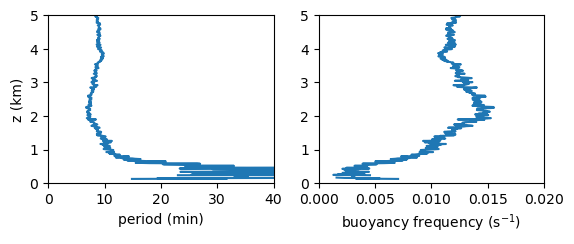

"slow omega<N, periods longer than 10 min, propagate"

In [9]:
# plot buoyancy frequency
close("all")
subplot(2,2,1)
plot((x->x>0 ? 2*pi/sqrt(x)/60 : NaN).(Nsq), (z[1:end-1].+5.0)./1e3)
ylim([0, 5])
xlim([0, 40])
ylabel("z (km)")
xlabel("period (min)")

subplot(2,2,2)
plot((x->x>0 ? sqrt(x) : NaN).(Nsq), (z[1:end-1].+5.0)./1e3)
ylim([0, 5])
xlim([0, 0.02])
xlabel("buoyancy frequency (s\$^{-1}\$)")
"slow omega<N, periods longer than 10 min, propagate"

In [35]:
# compute total all-sky flux G with cloud base BC

# cloud base vapor flux initial condition
Ecb = 180 # E0 - 35; just the cloud vapor flux
Gcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # _total_ flux F at cloud base
# F[icb] = Fcb # total flux at cloud base
# integrate total flux balancing subsidence
G = similarmissing(qm)
# A = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) # as above
G[icb:end] = Gcb .+ vcat(0, cumsum( S_ls[icb:end] ) * dz)

# icb = findfirst(.!ismissing.(F))
itop=lastindex(G)-1 

3099

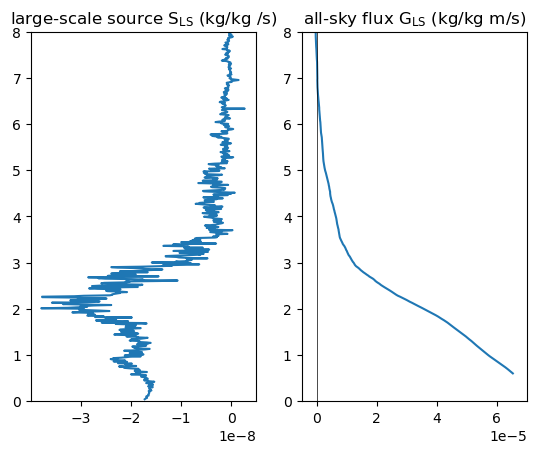

"The surface flux balances the large scale source integrated from CB to ~8 km."

In [ ]:
# plot G as a function of height
close("all")
subplot(1,2,1)
plot(S_ls, z[1:end-1]/1e3)
title("large-scale source S\$_\\text{LS}\$ (kg/kg /s)")
ylim([0, 8])

subplot(1,2,2)
plot(G, z/1e3)
plot([0, 0], [0, 8], "k-", linewidth=0.5)
title("all-sky flux G\$_\\text{LS}\$ (kg/kg m/s)")
ylim([0, 8])
xlim([-0.5e-5, 7e-5])
# gcf()
"The surface moisture flux balances the large scale source integrated from CB to ~8 km."


Is the mean precipitation (25 W m^-2) supposed to happen elsewhere, 
downstream of the trade cumulus regime?

Precipitation (mean 25 W m^-2) is intermittently scattered into the trade cumulus regime by moist tongues and synoptic convergence. 
We think of these convective enhancements as "downstream" along column quasi-Lagrangians because of their greater column moisture.

## cloud ensemble, heights and area fractions

### Method 1, Horizontally uniform cloud eddy flux:
We distribute the all-sky mean flux G to the all-cloud mean 
$F=a_{cld}^{-1} G$, and then *evenly* to each cloud. If each cloud at level z has the same mean flux F_i (z)=F(z), then the all sky flux is
$$
G(z)=∑F_i (z)[a_i H(h_i-z)]=F(z)∑[a_i H(h_i-z)]=a_{cld}(z)F_1(z)
$$
with total cloud fraction at height z of 
$a_{cld}(z)=∑[a_i H(h_i-z)]$ and Heaviside function $H(x)={1,x≥0;0,x<0}$. As the flux decreases with height, there are fewer clouds to carry the mean flux.

$F_i = F_1(z)$ does not depend on $i$.

Only count clouds with tops below height $z$, so $a_{cld}(z)$ decreases with height. 

So
$$
a_{cld}(z_k) = \sum_{i=1,k}a_i
$$

### Method 2, Vertically uniform cloud eddy flux: 
The all-sky mean flux profile $G(z)$ has a flux difference at each height $h_i$ of $(ΔG)_i=-[G(h_{i+1})-G(h_i)]$. This flux difference is assumed to be carried by the clouds with area fraction $a_i$ and height $h_i$, so the mean flux in cloud category $i$ is vertically uniform, 
$F_i=a_i^{-1} (ΔG)_i$.

This is the flux for each cloud category $i$. It is uniform from cloud base to $h_i$ and goes to zero above $h_i$.

### Method 1, Horizontally uniform cloud eddy flux

In [37]:
# calculate F1 - not used

# check cloud fraction
sum(rfv_nrm) ≈ maximum(rfv_acc) # true
# plot(rfv_acc, dsa[:cth_bin]) # decreases with height

# F1 = pd(G) ./ rfv_acc # dimension (category_i, z) ---WRONG---
# line up bins
offset = findfirst(x->x≈dsa[:cth_bin][1]*1e3, z) - 1 # 50
#test offset
z[offset] == dsa[:cth_bin][1]*1e3 # true; cth_bin starts at z=500


"""
calcF1(G, rfv_acc)
Horizontally uniform cloud eddy flux calcF1
We distribute the all-sky mean flux G to the all-cloud mean 
``F_1=a_{cld}^{-1} G``, and then *evenly* to each cloud. If each cloud at level z has the same mean flux F_i (z)=F(z), then the all sky flux is
```math
G(z)=∑F_i (z)[a_i H(h_i-z)]=F(z)∑[a_i H(h_i-z)]=a_{cld}(z)F_1(z)
```
with total cloud fraction at height z of 
``a_{cld}(z)=∑[a_i H(h_i-z)]`` 
and Heaviside function 
``H(x)={1,x≥0;0,x<0}``. 
As the flux decreases with height, there are fewer clouds to carry the mean flux.

``F_i = F_1(z)`` does not depend on ``i``.

Only count clouds with tops below height ``z``, so ``a_{cld}(z)`` 
decreases with height. 
So
```math
a_{cld}(z_k) = ∑_{i=1,k}a_i.
```
"""
function calcF1(G, rfv_acc)
    alignGi(G, rfv_acc) = G[offset.+eachindex(rfv_acc)]
    return alignGi(G, rfv_acc) ./ rfv_acc # dimension (z), does not depend on category_i
end

F1 = calcF1(G, rfv_acc)
F1mod = calcF1(G, rfv_acc.+0.02)

# calculate F2

# ΔG = -diff(G) # z grid
# prototype
# F2 = -diff(G)[offset.+eachindex(rfv_nrm)] ./ rfv_nrm[:] # dimension category_i
# rfv_acc[end] == 0.0

calcF2_(G, acc; sk=1) = diff(G[1:sk:end]) ./ diff(acc[1:sk:end]) # dimension category_i, inputs asligned!

"""
calcF2(G, rfv_acc)
Vertically uniform cloud eddy flux 
The all-sky mean flux profile ``G(z)`` has a flux difference 
at each height ``h_i`` of ``(ΔG)_i=-[G(h_{i+1})-G(h_i)]``. 
This flux difference is assumed to be carried by the clouds with 
area fraction ``a_i`` and height 
``h_i``, so the mean flux in cloud category ``i`` is vertically uniform, 
``F_i=a_i^{-1} (ΔG)_i``.

This is the flux for each cloud category ``i``. It is uniform from cloud base to ``h_i`` and goes to zero above ``h_i``.
"""
function calcF2(G, rfv_acc; sk)
    align2i(G) = G[offset.+eachindex(rfv_acc)] # dimension category_
    return calcF2_(align2i(G), rfv_acc; sk=sk) # inputs not aligned
end

F2 = calcF2(G, rfv_acc; sk=1)

# coarsen bin size to 100 m
F2c = calcF2(G, rfv_acc; sk=10)
# mean not weighted by area
# F2m = mean(skipmissing(nisf2m.(F2)))
# mean weighted by area
F2m = sum( skipmissing(nisf2m.(F2) .* rfv_nrm[1:end-1]) ) / sum( rfv_nrm )
"The mean flux over all cloud categories i is $(round(F2m*1e3, digits=2)) g/kg m/s = $(round(F2m*rhoL, digits=0)) W/m²"

"The mean flux over all cloud categories i is 0.68 g/kg m/s = 1658.0 W/m²"

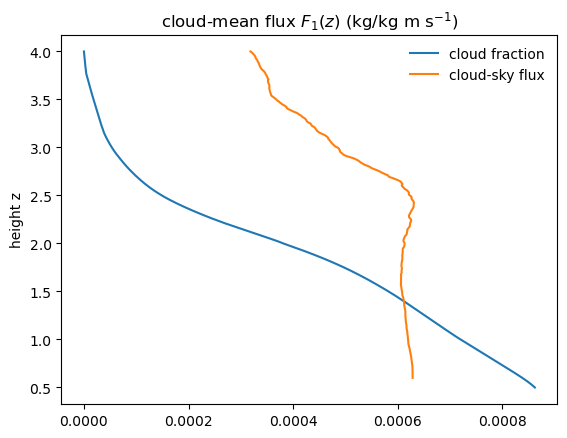

PyObject <matplotlib.legend.Legend object at 0x3577879a0>

In [38]:
# plot F1
close("all")
fig, ax = subplots(1,1)
plot(rfv_acc/1e2, dsa[:cth_bin], label="cloud fraction")
# plot(F1, dsa[:cth_bin], label="cloud-sky flux")
plot(F1mod, dsa[:cth_bin], label="cloud-sky flux")
ylabel("height z")
# xlim([-0.0005, 0.35]); ylim([0, 4.01])
title("cloud-mean flux \$F_1(z)\$ (kg/kg m s\$^{-1}\$)")
legend(frameon=false)
# gcf()


Almost all the flux is carried by the tallest clouds.

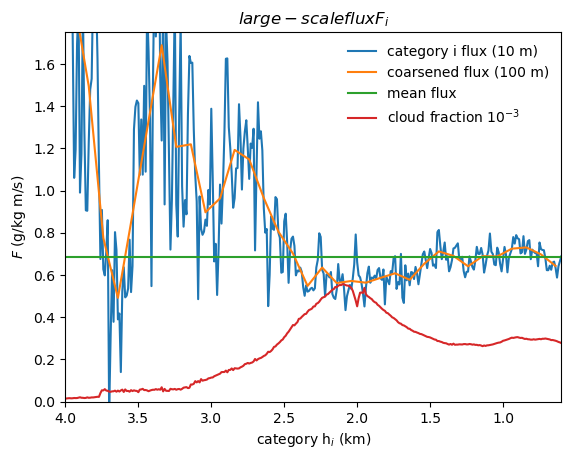

"Vertically uniform cloud-sky flux \$F_i\$ for each cloud category i.\nMean over all categories is 0.68 g/kg m/s = 1658.0 W/m²\n"

In [40]:
# plot F2

close("all")
figure()
plot(vec(dsa[:cth_bin][eachindex(F2)]), 1e3*F2, label="category i flux (10 m)")
plot(vec(dsa[:cth_bin][5:10:end-1]), 1e3*F2c, label="coarsened flux (100 m)")
plot([0.6, 4], [1e3, 1e3].*F2m, label="mean flux")
plot(vec(dsa[:cth_bin][eachindex(F2)]), 1e3*rfv_nrm[eachindex(F2)], label="cloud fraction 10\$^{-3}\$")
title("\$large-scale flux F_{i}\$")
legend(frameon=false)
xlabel("category h\$_i\$ (km)")
ylabel("\$F\$ (g/kg m/s)")
ylim([0, 1.75])
xlim([4, 0.6])
# gcf()
"""
Vertically uniform cloud-sky flux \$F_i\$ for each cloud category i.
Mean over all categories is $(round(F2m*1e3, digits=2)) g/kg m/s = $(round(F2m*rhoL, digits=0)) W/m²
"""

## cloud model

In [41]:
# cloud model - updraft total water and cloud water functions
# Updraft q_total, ql do not depend on F or Fcld.
# Below, mass flux W depends on q_total and Fcld.

"qtilde=(1-x)*qm .+ x*qs intermediate environmental moisture function"
function q_tilde(qm, qs, x)
    (1-x)*qm .+ x*qs
end

"updraft q_total function"
function q_total(aedz, x, qs, qm; i0, qt0, stopattop=false)
    qtilde=(1-x)*qm .+ x*qs
    qt = copy(qtilde)
    qt[1:i0] .= qt0 # cloud base initial condition
    # in cloud
    for i in i0:length(qt)-1
        if qt[i] > qs[i] # in cloud
            a = aedz
            Q = 0.5*(qtilde[i]+qtilde[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif !stopattop   # above cloud
            a = (1-x)*aedz  # no precipitation sink
            Q = 0.5*(qm[i]+qm[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif stopattop  # above cloud, stop at cloud top
            qt[i+1] = -999
        end
    end
    return qt
end

# cloud flux Fcld functions
# ql needs to be calculate by the cloud functions already
"""
Iterates up cloud flux modifying Fcld with precipitation efficiency x and total flux F.
Must initialize cloud base Fcld[icb] first!
"""
function cloudflux!(Fcld, x, ae, F, ql, qt, qm, icb=icb, itop=min(lastindex(F),findfirst(.!ismissing.(F) .&& F.<0)+20))
    Δq = qt .- qm
    c = @. -x*ae * ql / Δq * dz/2 # Q*dz stepping quantity # /2 added 2025 Aug 16
    # step Fcld through the trade Cu layer
    for i in icb:itop
        Fcld[i+1] = (F[i+1]-F[i] + Fcld[i]*(1+c[i])) / (1-c[i+1])                
    end
end

"integrate precipitation down to cloud base by stepping"
function precipflux_down_sfc(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    #P[istart] = 0.0
    P = 0.0 # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        # P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
        P = ( (1+c[i+1])*P + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    return P # at cloud base
end

"precipitation profile integrated downward from cloud top"
function precipflux_down!(P, x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    # P = zeros(size(F)) # at cloud top istart
    P[istart] = 0.0
    for i in (istart-1):-1:icb
        # update P by 1 step
        P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    P[1:icb-1] .= NaN
end

"precipitation profile integrated downward from cloud top"
function precipflux_down(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    P = zeros(size(F)) # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    P[1:icb-1] .= NaN # below cloud base
    return P # precip flux vector
end

precipflux_down

In [42]:
# align F2 to cloud model z grid
F2z = Array{Union{Missing, Float64}}(missing, size(qm))
F2z[offset.+eachindex(F2)] .= F2[:] 
# needs to be masked with 0 above cloud top
# plot(F2z)

350-element view(::Vector{Union{Missing, Float64}}, 51:400) with eltype Union{Missing, Float64}:
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
 0.0006892754354654233
 0.0006655016024307999
 0.0006416103934157793
 ⋮
 0.0018765540083905755
 0.0011726987913617682
 0.0009900841172119045
 0.0018855221077295845
 0.0016935773596736799
 0.0011938169837634308
 0.0010599436804751027
 0.0017626744700612773
 0.002315021870752285
 0.0022910427884339497
 0.0027769756353865837
 0.00349117924024463

In [ ]:
#= test the precip computation

# set parameters
ae = 3e-3
x = 0.5

# compute clouds
qtilde = q_tilde(qm, qs, x)
qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
itop = findlast(qt.-qs .> 0)
ql = max.(0, qt.-qs)

precipflux_down_sfc(x, ae, F2z, ql, qt, qm, istart=maximum(findall(ql.>0))+1, icb=icb) * rhoL
# W/m^2

# Find first local maximum
first_max(y) = findfirst(i -> y[i] > y[i-1] && y[i] > y[i+1], 2:length(y)-1) + 1

# Find global minimum after it
qc_min_idx(y) = first_max(y) + argmin(y[first_max(y)+1:end]) - 1
=#

In [44]:
# iterate cloud model for F2z_i

#cloud base and cloud top indices
ist = findfirst(z .>= 2000)
ien = findfirst(z .<= 5000)

"terminate the cloud at ql=0"
findcloudtop(ql) = findfirst(ql .== 0 .&& z .> zcb )

findshallowc(ql) = min(findcloudtop(ql) )

"terminate the cloud either at ql=0 or at the elevated minimum ql in the trade inversion"
function findcloudtop(ql, ist,ien)
    itop = findfirst(ql .== 0 .&& z .> zcb )
    if isnothing(itop) # choose the minimum 
        itop = argmin(ql[ist:ien]) + ist - 1
    end
    itop
end

# detect deep convective clouds
"max ql of low clouds, below 3600 m"
low_argmax(ql,z) = argmax(skipmissing(replace(ql, NaN=>missing) .* (z.<3600)))

"Find the minimum in cloud above the trade inversion. Shallow Cu cloud top should be below this."
function high_argmin(ql,z) 
    lax = low_argmax(ql,z)
    lst = findlast( z .< 3600 )
    argmin(skipmissing(replace(ql[lax:lst], NaN=>missing))) + lax - 1
end
"return true for deep clouds having no ql <= 0 between max ql of low cloud and 4 km"
deep_cloud(ql,z) = minimum(ql[low_argmax(ql,z):findfirst(z.>=4000)]) > 0.0

deep_cloud

In [45]:
#= detect the deep convective transition in an example cloud

x  = 0.5
ae = 5e-4

nz = length(z)
ff = Vector{Union{Missing, Float64}}(missing, nz)

# compute clouds
qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
ql = max.(0, qt.-qs)
itop = findlast(ql .> 0)
itop = findcloudtop(ql)
if !isnothing(itop) 
    ztop = z[itop] # ztop can be up to 20 km
    fill!(ff, F2z[itop]) # use uniform flux for the experiment's cloud top height
    if deep_cloud(ql,z)
        Pcb = 0 # zero out precip from deep clouds
    else
        Pcb = precipflux_down_sfc(x, ae, ff, ql, qt, qm, istart=itop, icb=icb)
    end
end

# plot example
qax = low_argmax(ql,z)
qan = high_argmin(ql,z)
close("all")
plot(ql[qax], qax,  marker="o", color="r")
plot(ql[qan], qan,  marker="o", color="y")
plot(ql, eachindex(ql))
# ylim([1650, 3600])
# xlim([0.002, 0.00204])
qax, qan, deep_cloud(ql,z)
=#

In [46]:
#= ensemble of clouds for sink rates and pcp efficiencies
# takes ~30 s

# parameter ranges for experiments
nx = 500
ns = 600
nz = length(z)
pcp_effic = range(0, 1, length=nx) #0:0.005:0.9         # precipitation efficiency
# tot_sink  = sqrt.(range(5e-4^2, 5e-3^2, length=ns)) # total sink rate α+ϵ
# tot_sink = (range(5e-4^pwr, 5e-3^pwr, length=ns)).^(1/pwr) # total sink rate α+ϵ, increasing
# tot_sink = tanh.(range(-pi, pi, length=ns)) .* (5e-3 - 5e-4)/2 .+ 5.5e-3/2
tot_sink = (1 .+tanh.(range(-8*pi, 0, length=ns))) .* (5e-3 - 1e-4) .+ 1e-4
# subplot(2,1,1)
# plot(tot_sink)

qtc  = Array{Union{Missing,Float64},3}(missing, nz, nx, ns)
Fcld = Array{Union{Missing,Float64},3}(missing, nz, nx, ns)
Fp   = Array{Union{Missing,Float64},3}(missing, nz, nx, ns)
Pcb  = Matrix{Union{Missing,Float64}}(missing, nx, ns)
ztop = Matrix{Union{Missing,Float64}}(missing, nx, ns)
zmin = Matrix{Union{Missing,Float64}}(missing, nx, ns)
ff = Vector{Union{Missing, Float64}}(missing, nz)
for ix in eachindex(pcp_effic)
    x = pcp_effic[ix]
    qtilde = q_tilde(qm, qs, x) # depends on precipitation efficiency
    for ia in eachindex(tot_sink)
        ae = tot_sink[ia]
        # compute clouds
        qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
        ql = max.(0, qt.-qs)
        # itop = findlast(ql .> 0)
        itop = findcloudtop(ql)
        zmin[ix,ia] = z[high_argmin(ql,z)]
        ztop[ix,ia] = z[itop] # ztop can be up to 20 km
        if !isnothing(itop) && !deep_cloud(ql,z)
            qtc[:,ix,ia] .= qt
            fill!(ff, F2z[itop]) # use uniform flux for the experiment's cloud top height
            # fill!(Fp, 0)
            Fp[:,ix,ia] .= -precipflux_down(     x, ae, ff, ql, qt, qm, istart=itop, icb=icb )
            Pcb[ix,ia] = -Fp[icb,ix,ia]
            # cloud updraft flux
            Fcld[:,ix,ia] .= -Fp[:,ix,ia] .+ F2z[itop]
            # cloud        = -precip         eddy
        end
    end
end

# cloud top height computed within 10 m
itop_ens = @. floor(Int32, ztop/10 - offset) + 1
cth = map( i -> i<=351 ? dsa[:cth_bin][i] : missing, itop_ens )
cth - ztop/1e3 # should be small differences
a_i = map( i -> i<=351 ? rfv_nrm[i] : 0, itop_ens ) # cloud area fractions _i (matrix)
"Low sink rates generate high clouds."
# takes 23 seconds on my laptop
=#

In [ ]:
# compute and fill w for all precipitation efficiencies

ntp = 500 # top ~5 km
dq = qtc[1:ntp,:,:] .- qm[1:ntp]

w = Array{Union{Missing, Float64},3}(missing, ntp, nx, ns)
w_ = Array{Union{Missing, Float64},2}(missing, ntp, ns)

for ix in eachindex(pcp_effic)
    w_ = Fcld[1:ntp,ix,:] ./ dq[1:ntp,ix,:]
    for i in axes(w_,2) # blank out w above clouds
        ii = z[axes(w_,1)] .> ztop[ix,i]
        w_[ii,i] .= missing
    end
    w[:,ix,:] = w_
end

In [ ]:
# compute a measure of cloud fraction da/dsink = da/dh * dh/dsink

"return the first unique indices of a"
uniqueind(a) = unique(i -> a[i], eachindex(a))

# not used?
function hmid_0_4km(h)
    nh = findfirst(x->x>=4000, h)
    hm = (h[1:nh-1] .+ h[2:nh]) / 2
end

function sortunique(ztop)
    ui_ = uniqueind(ztop[:])
    oi = sortperm(ztop[ui_])
    ui = ui_[oi]
end

"""
dadsinkrate(ztop, tot_sink, rfv_nrm, dh=10.0)
Compute cloud fraction density per unit sink rate 
da/dsinkrate = da/dh * dh/dsinkrate.
Interpolates satellite coordinate to model sinkrate coordiante.
"""
function dadsinkrate(ztop, tot_sink, rfv_nrm, dh=10.0)
    # condition vertical coordinate
    ui = sortunique(ztop)
    h = ztop[ui] # sorted ascending
    hm_ = (h[1:end-1] .+ h[2:end]) / 2
    ii = hm_ .<= 4000
    hm = hm_[ii]

    dh_dsink = diff(h) ./ diff(tot_sink[ui])

    # satellite coordinate --> da/dh
    da_dh = rfv_nrm[:] / dh
    # interpolate satellite a(h) to unique h_sink coordinate
    da_dh_to_sink = linear_interpolation((cth_bin*1e3,), da_dh).(hm) 
    da_dsink = da_dh_to_sink .* -dh_dsink[ii]
end

# usage later:
# da_dsink = dadsinkrate(ztop, tot_sink, rfv_nrm)

dadsinkrate

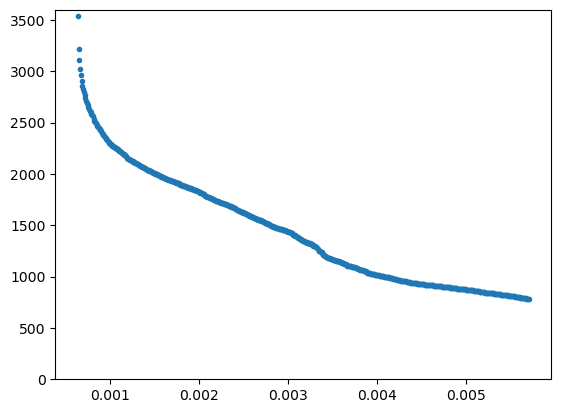

"Highest cloud top is 3.54 km for x=0.53 at sink rate 0.6352 km^-1.\n"

In [142]:
# refine cloud top for x=0.53

x = 0.53
# nx = 500
# pcp_effic = range(0, 1, length=nx) #0:0.005:0.9         # precipitation efficiency
nz = length(z)
ns = 600
# tot_sink = (1 .+tanh.(range(-8*pi, 0, length=ns))) .* (5e-3 - 1e-4) .+ 1e-4
# tot_sink = range(6.1716e-4, 5.8e-3, length=ns) # min tuned for x=0.53 to get the highest possible cloud top
tot_sink = range(6.3523e-4, 5.7e-3, length=ns) # min tuned for x=0.53 to get the highest possible cloud top

"Compute clouds and fluxes for a single precipitation efficiency x and a range of sink rates tot_sink."
function cloudflux_1x(tot_sink=tot_sink; x=x)
    qtc  = Array{ Union{Missing, Float64},2}(missing, nz, ns)
    Fcld = Array{ Union{Missing, Float64},2}(missing, nz, ns)
    Fp   = Array{ Union{Missing, Float64},2}(missing, nz, ns)
    # Pcb  = Matrix{Union{Missing, Float64}}(missing, ns)
    ztop = Vector{Union{Missing, Float64}}(missing, ns)
    # zmin = Matrix{Union{Missing, Float64}}(missing, ns)
    ff   = Vector{Union{Missing, Float64}}(missing, nz)

    # ix = findfirst( pcp_effic .>= x)
    qtilde = q_tilde(qm, qs, x) # depends on precipitation efficiency
    for ia in eachindex(tot_sink)
        ae = tot_sink[ia]
        # compute clouds
        qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
        ql = max.(0, qt.-qs)
        itop = findcloudtop(ql)
        ztop[ia] = z[itop] # ztop can be up to 20 km
        if !isnothing(itop) && !deep_cloud(ql,z)
            qtc[:,ia] .= qt
            fill!(ff, F2z[itop]) # use uniform flux for the experiment's cloud top height
            Fp[:,ia] .= -precipflux_down( x, ae, ff, ql, qt, qm, istart=itop, icb=icb )
            # Pcb[ia] = -Fp[icb,ia]
            # cloud updraft flux
            Fcld[:,ia] .= -Fp[:,ia] .+ F2z[itop]
            # cloud        = -precip         eddy
        end
    end
    ztop, Fcld, Fp, qtc
end

zt53, Fcld53, Fp53, qtc53 = cloudflux_1x(tot_sink; x=0.53)
Pcb53 = -Fp53[icb,:] # cloud base precip
# any(x->!ismissing(x), zt) # true!
ii = findall(x-> zcb+50<x<4000, zt53)
plot(tot_sink[ii], zt53[ii], marker=".", linestyle="none")
ylim([0, 3600])

"""
Highest cloud top is $(round(zt53[ii][1]/1e3, digits=2)) km \
for x=$(x) at sink rate $(round(tot_sink[ii[1]]*1e3, sigdigits=4)) km^-1.
"""

In [ ]:
# compute w for a single x and range of sink rates

function updraft_w_dq(Fcld, qtc, qm, ztop)
    dq = qtc .- qm
    w = convert(Matrix{Union{Missing,Float64}}, Fcld ./ dq)
    for i in axes(w,2) # blank out w above clouds
        ii = z .> ztop[i]
        w[ii,i] .= missing
    end
    return w, dq
end

w53, dq53 = updraft_w_dq(Fcld53, qtc53, qm, zt53)

# compute da/dsink for x=0.53
da_dsink = dadsinkrate(zt53, tot_sink, rfv_nrm)

3100×600 Matrix{Union{Missing, Float64}}:
 NaN         NaN         NaN         …  NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN         …  NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN         …  NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
 NaN         NaN         NaN            NaN         NaN         NaN
   ⋮                                 ⋱                          
    missi

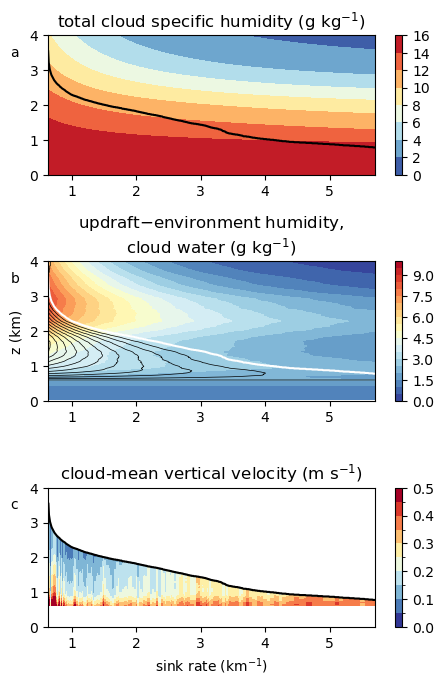

"FIG WPROF"

In [139]:
"Plot cloud profiles for a single precipitation efficiency x and a range of sink rates tot_sink."
function plot_qv_qc_w(tot_sink, z, da_dsink, ztop, qtc, Fcld, w, qm, qs; x=0.53, ntp=500)
    # vertical coordinate
    ui = sortunique(ztop)
    h = ztop[ui] # sorted ascending
    hm_ = (h[1:end-1] .+ h[2:end]) / 2
    ii = hm_ .<= 4000
    hm = hm_[ii]

    dq = qtc .- qm
    
    figure(figsize=(9, 11))

    subplot(5,2,1)
    contourf(tot_sink*1e3, z[1:ntp]/1e3, qtc[1:ntp,:]*1e3, cmap=ColorMap("RdYlBu_r"))
    cb = colorbar()
    plot(tot_sink*1e3, ztop[:]/1e3, "k", label="cloud top height")
    # plot(tot_sink[ui][1:end-1][ii]*1e3, 0.02*da_dsink, "w", linewidth=0.5, label="da/d(sink)")
    ylim([0, 4])
    title("total cloud specific humidity (g kg\$^{-1}\$)")
    text(0.05, 3.4, "a")

    subplot(5,2,3)
    contourf(tot_sink*1e3, z[1:ntp]/1e3, dq[1:ntp,:]*1e3, levels=0:0.5:10, vmin=0, vmax=10, cmap=ColorMap("RdYlBu_r"))
    cb = colorbar()
    contour(tot_sink*1e3, z[1:ntp]/1e3, max.(0,qtc[1:ntp,:].-qs[1:ntp])*1e3, levels=0:0.2:3, vmin=0, vmax=3, colors="k", linewidths=0.5)
    plot(tot_sink*1e3, ztop[:]/1e3, "w")
    ylim([0, 4])
    title("updraft\$-\$environment humidity,\ncloud water (g kg\$^{-1}\$)")
    # xlabel("sink rate (km\$^{-1}\$)")
    ylabel("z (km)")
    text(0.05, 3.4, "b")

    subplot(5,2,5)
    levs = 0:0.05:0.5
    norm = PyPlot.matplotlib.colors.BoundaryNorm(levs, 256)
    pcolormesh(tot_sink*1e3, z[1:ntp]/1e3, w[1:ntp,:], norm=norm, cmap=ColorMap("RdYlBu_r"))
    colorbar()
    plot(tot_sink*1e3, ztop[:]/1e3, "k", label="cloud top height")
    ylim([0, 4])
    xlabel("sink rate (km\$^{-1}\$)")
    title("cloud-mean vertical velocity (m s\$^{-1}\$)")
    text(0.05, 3.4, "c")

    tight_layout()
    return gca()
end

close("all")
plot_qv_qc_w(tot_sink, z, da_dsink, zt53, qtc53, Fcld53, w53, qm, qs)
fmt = split("png eps pdf svg")
[ savefig("wprof.$(f)") for f in fmt ]
"FIG WPROF"

In [146]:
#= area weighted integral functions - for computing precipitation
# for different precip efficiencies!

"interpolate accumulated cloud fraction with a continuous cloud top height variable ztop (m)"
# a_acc(z) = linear_interpolation((1e3*cth_bin,), Vector{Float64}(rfv_acc[:]))(z)
a_acc(z) = linear_interpolation((1e3*cth_bin,), rfv_acc[:])(z)
a_acc_const(z; constant=0) = z < 500 || z > 4000 ? constant : a_acc(z) 
# diffing this will result in a_acc - 0, which is an error
a_nrm(z) = linear_interpolation((1e3*cth_bin,), rfv_nrm[:])(z)
"integrate the quantity X(ztop) of the model clouds, weighted by fractional area"
function cloud_model_allsky_integral(ztop, X)
    function weightsum(ztop, X) # 1d vector operation
        valid_idx = broadcast(z-> !ismissing(z) && z > 600 && z < 4000, ztop) # valid clouds only
        da = a_nrm.(ztop[valid_idx])
        sum(skipmissing(X[valid_idx] .* da), init=0.0)
    end
    Xint = [weightsum(ztop[j,:], X[j,:]) for j in axes(ztop,1)] # second dimension is sink rate
end

Pcb_tot = cloud_model_allsky_integral(zt53, Pcb53) # for ensemble, not x=0.53
=#

Precipitation integral methods converge.

All-sky precipitation of $G_P = 25.4$ W m $^{-2}$ is never reached by the shallow cumulus clouds for any preciptiation efficiency.

For $x \approx 0.53$ cloudy-sky precipitaiton $F_{P,\text{ShCu}}$ from shallow cumulus equals the all-sky mean $G_P$.

The area fraction of shallow clouds is 0.08, of deep clouds is 0.02, and the clear fraction is 0.90. Taking the shallow Cu cloudy-sky mean equal to the all-sky mean, the mean of the 0.92 of the sky not in shallow cumulus (deep+clear) also has the all-sky mean. Thus,
$$
0.92G_P = 0.02F_{P,\text{deep}} \\
F_{P,\text{deep}} = (0.92/0.02) G_P 
 = 1170 \text{ W}\text{ m}^-2 \\
 = 0.47\times 10^{-3} \text{ kg}\text{ m}^{-2}\text{ s}^{-1} \\
 = 0.47\times 10^{-3} \text{ mm}\text{ s}^{-1} \\
 = 1.7\text{ mm}\text{ h}^{-1} \\
$$

In [ ]:
# save data in tradeCu_clouds_flux.nc
# It takes as long to save the data as it does to generate it.
ntp = 500
perm=(3,2,1)
m2n(x) = ismissing(x) ? NaN : x
poot(A) = m2n.(permutedims(A, perm)) # makes NetCDF compliant

# save data
let do_it=false
    if do_it
        df = Dataset( "tradeCu_clouds_flux.nc", "a", format=:netcdf4)

        # coordinates
        df[:height][:] = z[1:ntp]
        df[:precip_efficiency][:] = pcp_effic
        df[:total_sink_rate][:] = tot_sink
        # dependent variables
        df[:cloud_top_height][:,:] = pd(ztop)

        df[:flux_cloud][:,:,:] = m2n.(permutedims(Fcld[1:ntp,:,:], perm))
        df[:flux_eddy][:,:,:] = poot((Fcld .+ Fp)[1:ntp,:,:]) # F2z[h_i]
        sync(df)
        df[:flux_precip][:,:,:] = poot(Fp[1:ntp,:,:])
        df[:vert_vel][:,:,:]   = poot(w[1:ntp,:,:])
        sync(df)
        df[:q_total_cloud][:,:,:] = poot(qtc[1:ntp,:,:])

        df[:q_env][:] = m2n.(qm[1:ntp])
        df[:q_sat_env][:] = m2n.(qs[1:ntp])
        close(df)
    end
end

let do_it=false
    if do_it
        ntp = 500
        perm=(2,1)
        m2n(x) = ismissing(x) ? NaN : x
        poot(A) = m2n.(permutedims(A, perm)) # makes NetCDF compliant

        df = Dataset( "tradeCu_clouds_flux_xp53.nc", "a", format=:netcdf4)

        # coordinates
        df[:height][:] = z[1:ntp]
        df[:total_sink_rate][:] = tot_sink
        # dependent variables
        df[:cloud_top_height][:] = pd(zt53)

        df[:flux_cloud][:,:] = m2n.(permutedims(Fcld53[1:ntp,:], perm))
        df[:flux_eddy][:,:] = poot((Fcld53 .+ Fp53)[1:ntp,:]) # F2z[h_i]
        sync(df)
        df[:flux_precip][:,:] = poot(Fp53[1:ntp,:,:])
        df[:vert_vel][:,:]   = poot(w53[1:ntp,:,:])
        sync(df)
        df[:q_total_cloud][:,:] = poot(qtc53[1:ntp,:,:])

        df[:q_env][:] = m2n.(qm[1:ntp])
        df[:q_sat_env][:] = m2n.(qs[1:ntp])
        close(df)
    end
end

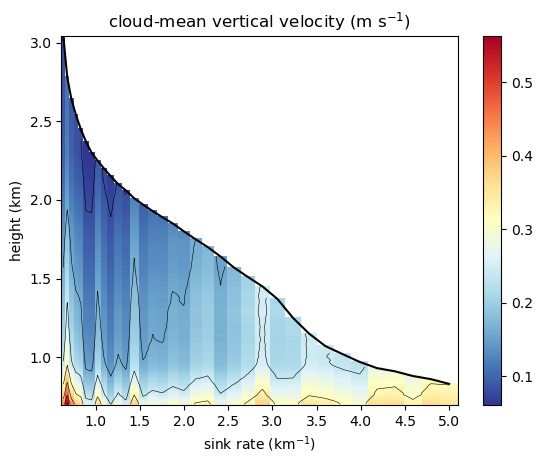

"has a quasi- lower triangular structure"

In [35]:
# subset w to diagnose vertical modes
ntp = 400
start_ae = findfirst(any(x->!ismissing(x) && isfinite(x), w[:,ix,:], dims=1)[:])
start_cb = findfirst(any(x->!ismissing(x) && isfinite(x), w[:,ix,:], dims=2)[:])
stop_top = findlast(any(x->!ismissing(x) && isfinite(x), w[:,ix,:], dims=2)[:])
close("all")
pcolormesh(tot_sink[start_ae:end]*1e3, z[start_cb:stop_top]/1e3, w[start_cb:stop_top,ix,start_ae:end], cmap=ColorMap("RdYlBu_r"))
colorbar()
contour(tot_sink[start_ae:end]*1e3, z[start_cb:stop_top]/1e3, w[start_cb:stop_top,ix,start_ae:end], linewidths=0.4, colors="k")
plot(tot_sink[start_ae:end]*1e3, ztop[ix,start_ae:end]/1e3, "k", label="cloud top height")
# ylim([0, 4])
ylabel("height (km)")
xlabel("sink rate (km\$^{-1}\$)")
title("cloud-mean vertical velocity (m s\$^{-1}\$)")
"has a quasi- lower triangular structure"

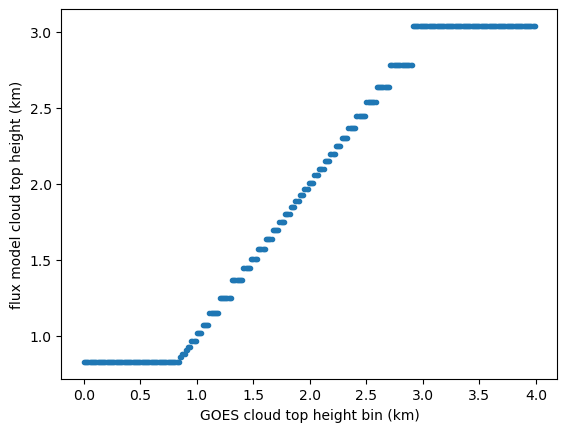

(3790, 3040.0)

In [84]:
# load cloud fraction by reflectance data from ATOMIC-GOES
pwd()
@load "../../../ATOMIC_GOES/julia/cth_cloudfrac_byrefl.jld2" refl_bin cthbins cth_cloudfrac_byrefl cloudfrac_byrefl area_byrefl cth_cloudarea_byrefl cloudarea_byrefl

# align cloud top height bins to model z grid (0.5-4 km)
# iz = [ searchsortedlast(z[1:ntp], b) for b in cthbins[1:ntp] ] # iterate through the cthbins and find the last index of z <= each cthbin
# z[1:ntp] == cthbins[1:ntp] # true 
# iz == 1:ntp # true

# align cloud top height bins to ztop of modeled clouds
# iz = [ searchsortedfirst(ztop[ix,:], b, rev=true) for b in cthbins[1:ntp] ] # iterate through the cthbins and find the last index of z <= each cthbin
iz = searchsortedfirst.(Ref(ztop[ix,:]), cthbins[1:ntp], rev=true)
# ^ right but returns out of range indices
ii = findall(0 .< iz .<= size(ztop,2)) # true for some bins above 4 km

# find nearest neighbor indices
iz = [argmin(abs.(ztop[ix,:] .- b)) for b in cthbins[1:ntp]]
ii = findall(0 .< iz .<= size(ztop,2)) # true for some bins above 4 km

# plot(ztop[ix,:], marker=".", linestyle="none")
plot(cthbins[ii]/1e3, ztop[ix,iz[ii]]/1e3, marker=".", linestyle="none")
xlabel("GOES cloud top height bin (km)")
ylabel("flux model cloud top height (km)")
cthbins[380], ztop[ix,iz[380]]